Задача

1. Проанализируйте тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?
2. Проанализируйте тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?

In [1]:
# Загружаю необходимые библиотеки.

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pandahouse

from scipy import stats

In [2]:
# Соединение.

connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230420'
}

In [3]:
# Считаю количество лайков и просмотров на юзера, ctr (с фильтрацией по датам экспериментов).

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-04-01' and '2023-04-07'
GROUP BY exp_group, user_id
"""

In [4]:
# Выгружаю данные в пандовский датафрейм.

df = pandahouse.read_clickhouse(q, connection=connection)

In [5]:
df.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,9,30,0.300000
1,1,18392,7,32,0.218750
2,3,123580,13,48,0.270833
3,2,131473,14,134,0.104478
4,4,107323,5,31,0.161290


#### 1. А/Б тест между группами 0 и 3 по метрике линеаризованных лайков.

In [6]:
# Перезаписываю данные для групп 0 и 3 в отдельный датафрейм.

df_03 = df[(df.exp_group == 0) | (df.exp_group == 3)]

In [7]:
df_03.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,9,30,0.300000
2,3,123580,13,48,0.270833
7,0,30319,21,110,0.190909
9,3,118359,7,38,0.184211
11,0,7626,14,39,0.358974


In [8]:
# Проверяю, сколько пользователей попало в каждую группу.

df_03 \
    .groupby('exp_group', as_index=False) \
    .user_id.count() \
    .rename(columns={'user_id':'user_count'})

,exp_group,user_count
0,0,9999
1,3,10049


Для сырых данных.

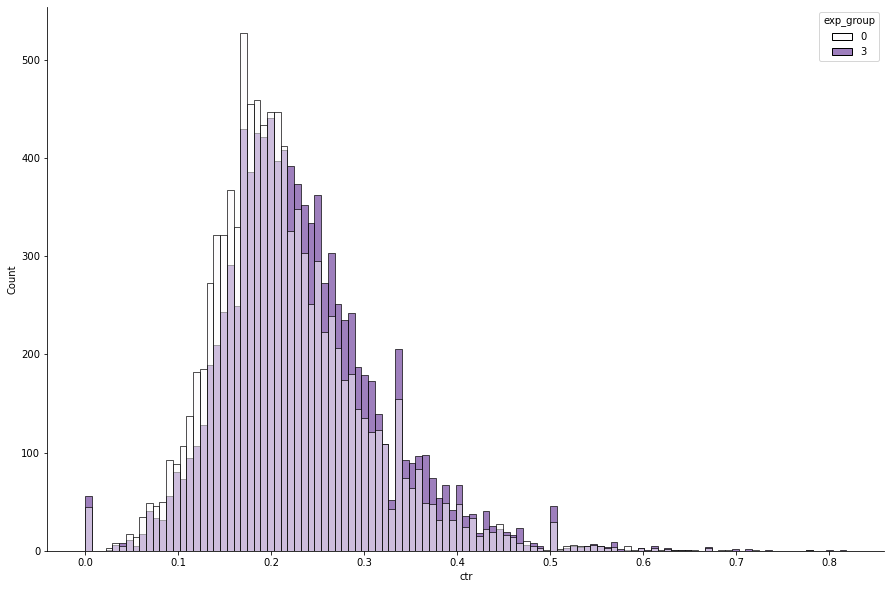

In [9]:
# Распределение метрики CTR для двух групп.

plt.figure(figsize=(15, 10))

sns.histplot(data=df_03, x='ctr', hue='exp_group', palette='Purples')
sns.despine()
plt.show()

In [10]:
# t-test на сырых значениях ctr.
# H0: μ0 = μ3
# H1: μ0 != μ3

stat, p = stats.ttest_ind(df_03[df_03.exp_group == 0].ctr, df_03[df_03.exp_group == 3].ctr, equal_var=False)

if p >= 0.05:
    print(f'p-value = {p}, \nпри α = 0.05 мы не можем отклонить H0 о равенстве средних значений.')
else:
    print(f'p-value = {p}, \nпри α = 0.05 были обнаружены статистически значимые различия средних значений двух групп.')

p-value = 1.055849414662529e-43, 
при α = 0.05 были обнаружены статистически значимые различия средних значений двух групп.


Линеаризованные лайки.

In [11]:
# Считаю общий CTR в контрольной группе (контрольная группа - 0).

ctr_control = df[df.exp_group == 0].likes.sum() / df[df.exp_group == 0].views.sum()

ctr_control

0.20823612262916305

In [12]:
# Считаю линеаризованные лайки.

df_03 = df_03.assign(lin_likes=df_03.apply(lambda x: x.likes - ctr_control * x.views, 1))

In [13]:
df_03.head()

,exp_group,user_id,likes,views,ctr,lin_likes
0,3,115383,9,30,0.300000,2.752916
2,3,123580,13,48,0.270833,3.004666
7,0,30319,21,110,0.190909,-1.905973
9,3,118359,7,38,0.184211,-0.912973
11,0,7626,14,39,0.358974,5.878791


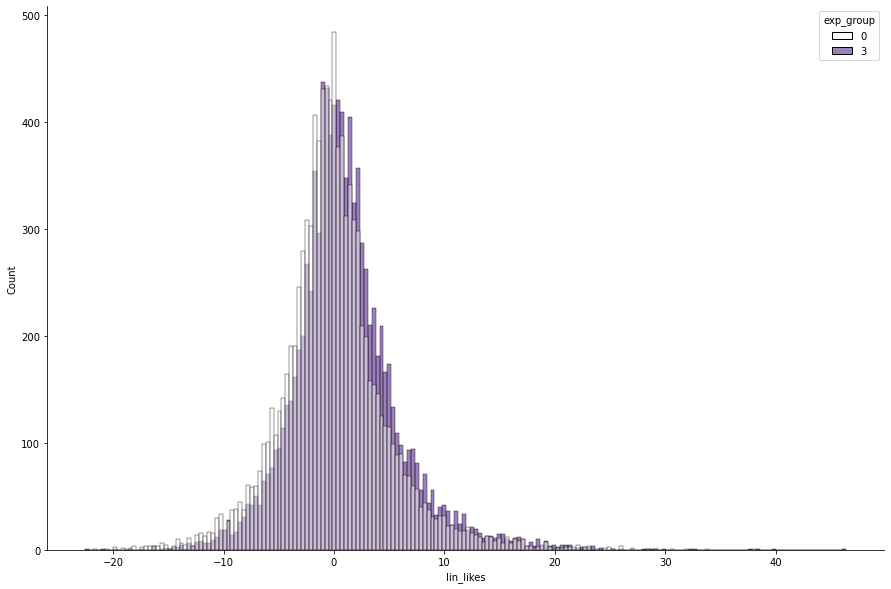

In [14]:
# Распределение метрики линеаризованных лайков для двух групп.

plt.figure(figsize=(15, 10))

sns.histplot(data=df_03, x='lin_likes', hue='exp_group', palette='Purples')
sns.despine()
plt.show()

In [15]:
# t-test на метрике линеаризованных лайков.
# H0: μ0 = μ3
# H1: μ0 != μ3

stat, p = stats.ttest_ind(df_03[df_03.exp_group == 0].lin_likes, df_03[df_03.exp_group == 3].lin_likes, equal_var=False)

if p >= 0.05:
    print(f'p-value = {p}, \nпри α = 0.05 мы не можем отклонить H0 о равенстве средних значений.')
else:
    print(f'p-value = {p}, \nпри α = 0.05 были обнаружены статистически значимые различия средних значений двух групп.')

p-value = 5.4914249479690016e-52, 
при α = 0.05 были обнаружены статистически значимые различия средних значений двух групп.


#### 1. А/Б тест между группами 1 и 2 по метрике линеаризованных лайков.

In [16]:
# Перезаписываю данные для групп 1 и 2 в отдельный датафрейм.

df_12 = df[(df.exp_group == 1) | (df.exp_group == 2)]

In [17]:
df_12.head()

,exp_group,user_id,likes,views,ctr
1,1,18392,7,32,0.218750
3,2,131473,14,134,0.104478
5,2,32420,26,128,0.203125
6,2,24239,40,90,0.444444
8,1,27443,2,29,0.068966


In [18]:
# Проверяю, сколько пользователей попало в каждую группу.

df_12 \
    .groupby('exp_group', as_index=False) \
    .user_id.count() \
    .rename(columns={'user_id': 'user_count'})

,exp_group,user_count
0,1,10079
1,2,9952


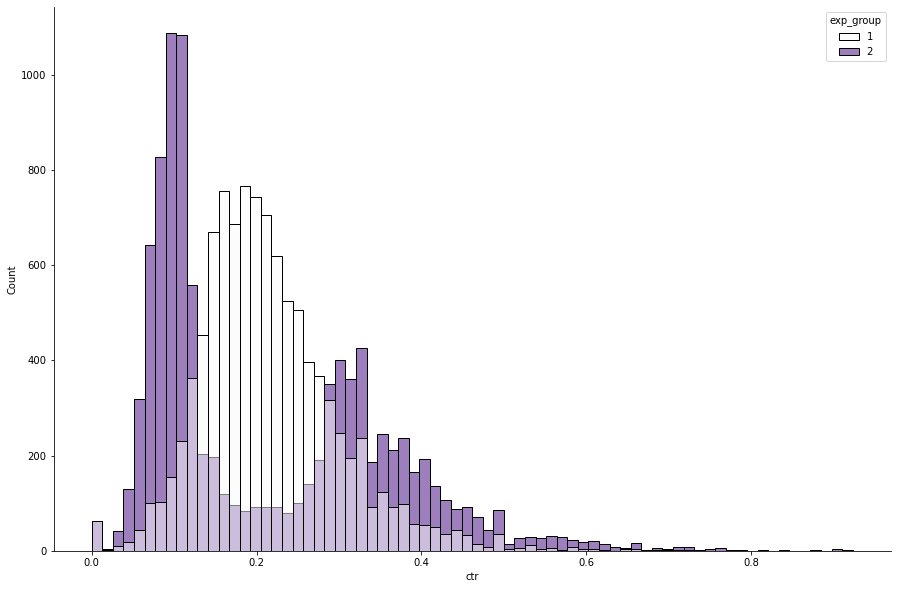

In [19]:
# Распределение метрики CTR для двух групп.

plt.figure(figsize=(15, 10))

sns.histplot(data=df_12, x='ctr', hue='exp_group', palette='Purples')
sns.despine()
plt.show()

Распределение метрики ctr у группы 2 бимодальное - отчетливо видны два пика(моды), а также длинный правый хвост. Распределение метрики ctr у группы 1 нормальное - распределение имеет 1 моду и является симметричным. 

Подобное распределение у группы 1 может быть связано со следующим:
1. Для группы 2 характерен более длинный правый хвост - большее количество людей ставило более 60 лайков. 
2. Также в группе 2 было больше пользователей, которые поставили около 5 лайков в сравнении с группой 1.

In [20]:
# t-test на сырых значениях ctr.
# H0: μ1 = μ2
# H1: μ1 != μ2

stat, p = stats.ttest_ind(df_12[df_12.exp_group == 1].ctr, df_12[df_12.exp_group == 2].ctr, equal_var=False)

if p >= 0.05:
    print(f'p-value = {p}, \nпри α = 0.05 мы не можем отклонить H0 о равенстве средних значений.')
else:
    print(f'p-value = {p}, \nпри α = 0.05 были обнаружены статистически значимые различия средних значений двух групп.')

p-value = 0.4780623130874935, 
при α = 0.05 мы не можем отклонить H0 о равенстве средних значений.


Я бы не стала опираться на результаты t-testa с выборками, одна из которых(группа 2) имеет явное бимодальное распределение, длинный правый хвост и большой разброс значений(дисперсия тоже будет большой) -> смещенная оценка среднего значения. 

Линеаризованные лайки.

In [21]:
# Считаю общий CTR в контрольной группе (контрольная группа - 1).

ctr_control = df[df.exp_group == 1].likes.sum() / df[df.exp_group == 1].views.sum()

ctr_control

0.20802680490126244

In [22]:
# Считаю линеаризованные лайки.

df_12 = df_12.assign(lin_likes = df_12.apply(lambda x: x.likes - ctr_control * x.views, 1))

In [23]:
df_12.head()

,exp_group,user_id,likes,views,ctr,lin_likes
1,1,18392,7,32,0.218750,0.343142
3,2,131473,14,134,0.104478,-13.875592
5,2,32420,26,128,0.203125,-0.627431
6,2,24239,40,90,0.444444,21.277588
8,1,27443,2,29,0.068966,-4.032777


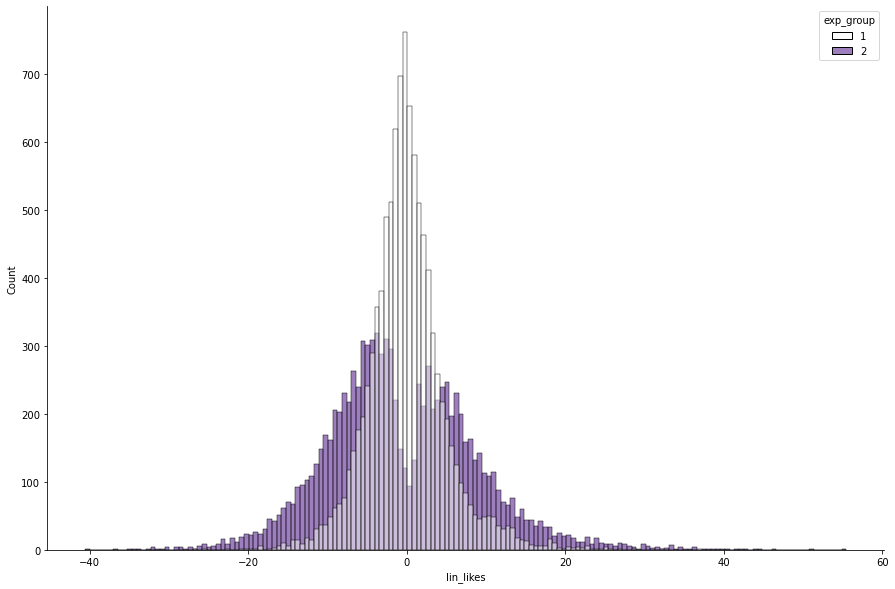

In [24]:
# Распределение метрики линеаризованных лайков для двух групп.

plt.figure(figsize=(15, 10))

sns.histplot(data=df_12, x='lin_likes', hue='exp_group', palette='Purples')
sns.despine()
plt.show()

По визуальной оценке оба распредления линеаризованных лайков являются нормальными - имеют одну моду и являются симметричными. Разброс значений у группы 2 явно больше.

In [25]:
# t-test на метрике линеаризованных лайков.
# H0: μ1 = μ2
# H0: μ1 != μ2

stat, p = stats.ttest_ind(df_12[df_12.exp_group == 1].lin_likes, df_12[df_12.exp_group == 2].lin_likes, equal_var=False)

if p >= 0.05:
    print(f'p-value = {p}, \nпри α = 0.05 мы не можем отклонить H0 о равенстве средних значений.')
else:
    print(f'p-value = {p}, \nпри α = 0.05 были обнаружены статистически значимые различия средних значений двух групп.')

p-value = 9.439432187037644e-10, 
при α = 0.05 были обнаружены статистически значимые различия средних значений двух групп.


#### Вывод
1. Значения ctr у групп 0 и 3 в целом распределены нормально (распределения имеют по одной моде и в целом являются симметричными, но есть достаточные выбросы). t-test на сырых значениях ctr и t-test на метрике линеаризованных лайков дали схожий результат -> мы смогли отклонить H0. <br>  Можно сказать, что данные для групп 0 и 3 являются "беспроблемными". На таких данных мощности t-test-а на сырых значениях ctr оказалось достаточно, чтобы найти значимые отличия в средних значениях ctr сравниваем групп. Метрика линеаризованных лайков является более чувствительной, поэтому по результатам t-test-а было получено меньшее значение p-value.

2. Значения ctr у группы 1 распределены нормально, у группы 2 распределение значений ctr имеет две моды, длинный правый хвост и большой размах данных. t-test на сырых значениях ctr и t-test на метрике линеаризованных лайков дали противоположные результаты: t-test на сырых значениях ctr не позволил отклонить H0, в то время как t-test на метрике линеаризованных лайков смог задетектировать статистически значимые различия между сравниваемыми группами. <br> Я бы не стала опираться на результаты t-testa на сырых значениях ctr с выборками, одна из которых(группа 2) имеет явное бимодальное распределение, длинный правый хвост и большой разброс значений(дисперсия тоже будет большой) -> смещенная оценка среднего значения.